In [4]:
from qiskit_algorithms.utils import algorithm_globals

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN

import time
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit import QuantumRegister,ClassicalRegister
from IPython.display import clear_output

from scipy.special import rel_entr
import pickle

In [5]:

def countZero(x):
    '''
    A function that evaluates the bitstring, all 0 bitstring gets mapped to 0 
    '''
    out=f"{bin(x)}".count("1")
    if out==0:
        return 0
    else:
        return 1

def make_ansatz(qc_ansatz,num_layers,num_qubits,weights):
    params_index = 0 #index counter
    for layer in range(num_layers):
              
        for i in range(num_qubits):
            qc_ansatz.rx(weights[params_index],i)
            params_index += 1
            
        for i in range(num_qubits):
            qc_ansatz.ry(weights[params_index],i)
            params_index += 1
            
        for i in range(num_qubits):
            qc_ansatz.rz(weights[params_index],i)
            params_index += 1
            
        for i in range(num_qubits-1):
            qc_ansatz.cy(i,i+1)
               
    return qc_ansatz

#A function that gives the Unitary of some ansatz.
def make_ansatz_unitary(num_layers,num_qubits,params):
    qr = QuantumRegister(num_qubits,'qr') #quantum register
    cr = ClassicalRegister(num_qubits,'cr') #classical register
    qc = QuantumCircuit(qr,cr) #construct ansatz
    qc=make_ansatz(qc,num_layers,num_qubits,params)
    qc.draw('mpl')
    return qi.Operator(qc)

#Create the sampler that computes the HS cost.
def mkSampler(U_target):
    inputs = ParameterVector("input", 0)
    weights = ParameterVector("weight", n_params)
    #print(f"input parameters: {[str(item) for item in inputs.params]}")
    #print(f"weight parameters: {[str(item) for item in weights.params]}")
    params_index=0
    qc = QuantumCircuit(2*n_qubits)
    qr=qc.qubits
    A = [qr[i] for i in range(n_qubits)]
    B = [qr[i] for i in range(n_qubits,n_qubits*2)]


    qc.h(A)
    qc.barrier()
    qc.cx(A,B)
    qc.barrier()
    for layer in range(n_layers):        
            for i in range(n_qubits):
                qc.rx(weights[params_index],i)
                params_index += 1

            for i in range(n_qubits):
                qc.ry(weights[params_index],i)
                params_index += 1

            for i in range(n_qubits):
                qc.rz(weights[params_index],i)
                params_index += 1
                
            for i in range(n_qubits-1):
                qc.cy(i,i+1)
                
    qc.unitary(U_target.conjugate(),qubits=B, label='$U_{target}^{*}$')
    qc.barrier()
    qc.cx(A,B)
    qc.barrier()
    qc.h(A)
    qc.barrier()
    sampler_qnn = SamplerQNN(circuit=qc,input_params=inputs, weight_params=weights,
                         interpret=countZero,output_shape=2
                        )
    return qc,sampler_qnn
    
    
    
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()

In [352]:
n_qubits=5
dims=2**n_qubits
n_layers=2
n_params=n_qubits*n_layers*3
#shots = 1000
#sampler = Sampler(options={"shots": shots})

n_train=100
zeroState = '0'
for i in range(n_qubits-1):
    zeroState+='0'

In [353]:
# Create a target U
targetParams=np.random.rand(n_params)*np.pi*2
U_target=make_ansatz_unitary(num_qubits=n_qubits,num_layers=n_layers,params=targetParams)
U_target=np.array(U_target)

In [354]:
qc,sampler=mkSampler(U_target)
print("number of parameters: ",qc.num_parameters)
sampler_input = np.array([])
sampler_weights = algorithm_globals.random.random(sampler.num_weights)

number of parameters:  30


In [355]:
def getMag(x):
    x2=x**2
    return np.sqrt(x2.sum())

def getCos(x,y):
    cos=(x*y).sum()/(getMag(x)*getMag(y))
    return cos

def getDot(sampler,weights,rate):
    input_grad,weight_grad=sampler.backward(sampler_input,weights)
    grad0=weight_grad[0][1]
    
    newWeights=weights-rate*grad0
    input_grad,weight_grad=sampler.backward(sampler_input,newWeights)
    grad1=weight_grad[0][1]
    
    
    return getCos(grad0,grad1),grad0,newWeights
    

In [356]:
t1=time.time()
weights=sampler_weights
sampler.forward(sampler_input,weights)
print(time.time()-t1)

0.03456377983093262


In [357]:
t1=time.time()
sampler.backward(sampler_input,weights)
print(time.time()-t1)

0.5421533584594727


In [358]:
def iteration(sampler,input_weights,steps=15,ini_rate=1e-1):
    dot_list=[]
    r_list=[]
    w_list=[]
    grad_list=[]
    weights=input_weights
    output_weights=input_weights
    output_rate=ini_rate
    rate=ini_rate
    for i in range(steps):
        dot,grad,weights=getDot(sampler,weights,rate)
        rate=rate*2

        if dot < -0.3:
            print("dot stop")
            output_rate=rate
            #output_weights=weights
            output_weights=(w_list[-1]+weights)/2
            break
            
        if i>1 and dot_list[-1]-dot>0.3:
            print("dot diff stop, dot= ",dot_list[-1],dot)
            if dot>0:
                output_weights=weights
                output_rate=rate
            elif dot<=0:
                output_rate=rate
                output_weights=(w_list[-1]+weights)/2
        
            break
            
            
        
        dot_list.append(dot)
        r_list.append(rate)
        w_list.append(weights)
        grad_list.append(grad)
            
    if output_weights.all()==weights.all():
        dot_list=np.array(dot_list)
        diff=(dot_list[0:-1]-dot_list[1:])
        index=np.where(diff==diff.max())[0][0]
        output_weights=w_list[index]
        output_rate=r_list[index]
        
    
    return output_weights,output_rate
        

dot stop


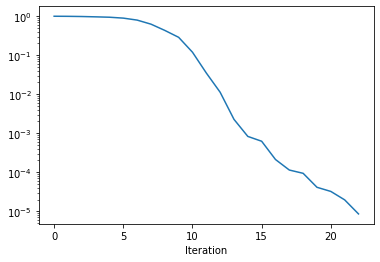

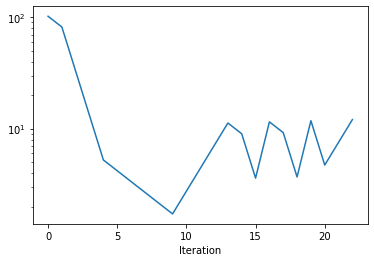

In [359]:
weights=sampler_weights
ini_rate=1e-1
cost_list_DIAG=[]
rate_list=[]
for i in range(n_train):
    clear_output(wait=True)
    weights,rate=iteration(sampler,weights,steps=20,ini_rate=ini_rate)
    ini_rate=rate/10
    cost=sampler.forward(sampler_input,weights)[0][1]
    cost_list_DIAG.append(cost)
    rate_list.append(rate)

    plt.figure(1)

    plt.xlabel('Iteration')
    plt.plot(range(len(cost_list_DIAG)),cost_list_DIAG)
    plt.yscale('log')
    plt.show()
    
    plt.figure(2)
    plt.xlabel('Iteration')
    plt.plot(range(len(rate_list)),rate_list)
    plt.yscale('log')
    plt.show()
    
    if cost<1e-5:
        break
    print(i, cost,rate)
    

DIAG+LBFGS

In [360]:
import torch
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit_machine_learning.connectors import TorchConnector
from torch.optim import Adam,SGD

In [361]:
def train_LBFGS_pytorch(sampler,lr=1e-1,max_iter=150,init = algorithm_globals.random.random(sampler.num_weights)):
    
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = LBFGS(sampler_torch.parameters(),lr=lr, max_iter=max_iter)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))
    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]
    # Define LBFGS closure method (explained in previous section)
    def closure():
        global costList
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        #if(len(costList)%20==0):
        print(cost)

        return loss

    # Run optimizer (LBFGS requires closure)
    optimizer.step(closure);
        
    return costList
    

dot diff stop, dot=  0.7059793268716451 0.19217407565550562


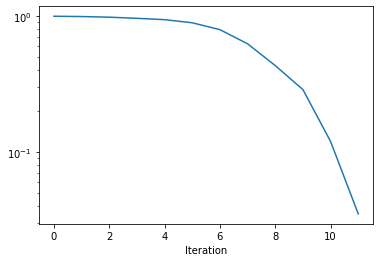

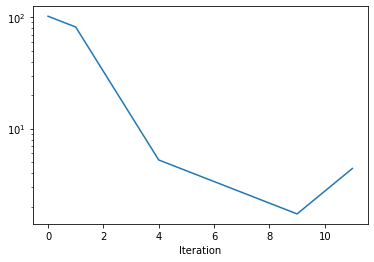

11 0.0350026311582319 4.398046511104001
0.03500263114979936
0.0334310086944267
0.012784467310928003
0.005145786642113499
0.0012522815801961006
0.0008713770604954005
0.0005489765802804004
0.0003464419399188001
0.00023307006018049995
0.00017165499314189992
0.00011661945864590002
7.658224437340002e-05
4.22102197808e-05
1.7286069062000002e-05
7.269583794199995e-06
3.022203410600001e-06
1.0507690451999997e-06
3.0637691759999977e-07
7.99173917e-08
2.969518909999999e-08
1.1158929499999998e-08
10.269513845443726


In [362]:
weights=sampler_weights
ini_rate=1e-1
cost_list=[]
rate_list=[]
for i in range(n_train):
    clear_output(wait=True)
    weights,rate=iteration(sampler,weights,steps=20,ini_rate=ini_rate)
    ini_rate=rate/10
    cost=sampler.forward(sampler_input,weights)[0][1]
    cost_list.append(cost)
    rate_list.append(rate)

    plt.figure(1)

    plt.xlabel('Iteration')
    plt.plot(range(len(cost_list)),cost_list)
    plt.yscale('log')
    plt.show()
    
    plt.figure(2)
    plt.xlabel('Iteration')
    plt.plot(range(len(rate_list)),rate_list)
    plt.yscale('log')
    plt.show()
    
    print(i, cost,rate)
    
    if cost<0.1:
        break

cost_list_LBFGS=[]
t1=time.time()
cost_list_LBFGS=train_LBFGS_pytorch(sampler,init=weights,lr=rate/10,max_iter=n_train)
print(time.time()-t1)
cost_list_DIAG_LBFGS  = cost_list+cost_list_LBFGS

In [363]:
import torch
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit_machine_learning.connectors import TorchConnector
from torch.optim import Adam,SGD

In [364]:
def train_ADAM_pytorch(sampler,lr=1e-1,max_iter=100):
    init = algorithm_globals.random.random(sampler.num_weights)
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = Adam(sampler_torch.parameters(),lr=lr)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))

    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]

    for i in range(max_iter):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        print(cost)
        optimizer.step();
        if cost<1e-5:
            break

    return costList
    

In [365]:
# t1=time.time()
# cost_list_ADAMtorch_1en1=train_ADAM_pytorch(sampler,lr=1e-1,max_iter=n_train)
# print(time.time()-t1)

In [366]:
# t1=time.time()
# cost_list_ADAMtorch_1e0=train_ADAM_pytorch(sampler,lr=1e0,max_iter=n_train)
# print(time.time()-t1)

In [367]:
def train_LBFGS_pytorch(sampler,lr=1e-1,max_iter=150):
    init = algorithm_globals.random.random(sampler.num_weights)
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = LBFGS(sampler_torch.parameters(),lr=lr, max_iter=max_iter)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))
    #print(sampler.forward(sampler_input,init))
    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]
    # Define LBFGS closure method (explained in previous section)
    def closure():
        global costList
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        #if(len(costList)%20==0):

        return loss

    # Run optimizer (LBFGS requires closure)
    optimizer.step(closure);
        
    return costList
    

In [368]:
learning_rate_list=[1e-3,1e-2,5e-2,1e-1,5e-1,1e0,5e0,1e1,5e1,1e2,1e3]

In [369]:
test_iter=30
finalCost_list=[]

for learning_rate in learning_rate_list:
    cost_list_LBFGStorch_test=[]

    cost_list_LBFGStorch_test=train_LBFGS_pytorch(sampler,lr=learning_rate,max_iter=test_iter)
    finalCost_list.append(cost_list_LBFGStorch_test[-1])
    print("finishing ",learning_rate, " final cost =",cost_list_LBFGStorch_test[-1])
    
finalCost_list=np.array(finalCost_list)
ind=np.where(finalCost_list==finalCost_list.min())[0][0]
best_rate=learning_rate_list[ind]
print("best learning rate =",best_rate)

finishing  0.001  final cost = 0.9999033424904245
finishing  0.01  final cost = 0.9995133108316593
finishing  0.05  final cost = 0.9988074720896651
finishing  0.1  final cost = 0.9994134592660017
finishing  0.5  final cost = 0.9988745163808901
finishing  1.0  final cost = 0.9989291872020688
finishing  5.0  final cost = 0.9957610852762419
finishing  10.0  final cost = 0.9961293937394134
finishing  50.0  final cost = 0.9999049925836945
finishing  100.0  final cost = 0.9995241835200214
finishing  1000.0  final cost = 0.9998286162969846
best learning rate = 5.0


In [370]:
cost_list_LBFGStorch_best=[]
cost_list_LBFGStorch_best=train_LBFGS_pytorch(sampler,lr=best_rate,max_iter=n_train)


<Figure size 432x288 with 0 Axes>

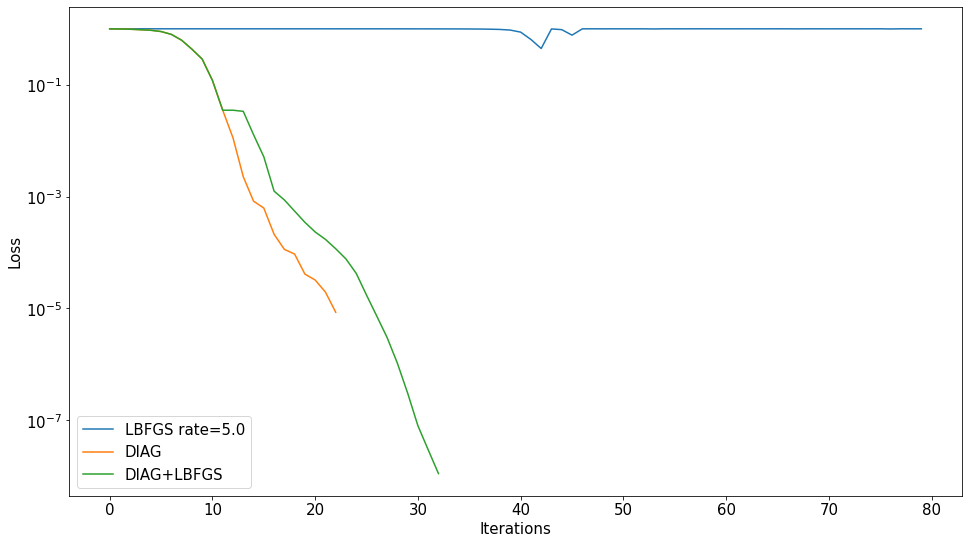

In [371]:
LabelSize=15
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
# plt.ylim(1e-5,1.1)

# plt.plot(range(len(cost_list_ADAMtorch_1en1)),cost_list_ADAMtorch_1en1,label='ADAM initial = 1e-1')
# plt.plot(range(len(cost_list_ADAMtorch_1e0)),cost_list_ADAMtorch_1e0,label='ADAM initial = 1e0')

plt.plot(range(len(cost_list_LBFGStorch_best)),cost_list_LBFGStorch_best,label='LBFGS rate={}'.format(best_rate))

plt.plot(range(len(cost_list_DIAG)),cost_list_DIAG,label='DIAG')
plt.plot(range(len(cost_list_DIAG_LBFGS)),cost_list_DIAG_LBFGS,label='DIAG+LBFGS')
plt.yscale('log')

plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)